In [1]:
#import necessary libraries 



import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [2]:
#races data

df_races = pd.read_csv("races.csv")

#result data
df_results = pd.read_csv("results.csv")

#drivers data
df_drivers = pd.read_csv("drivers.csv")

#constructor_results data
df_constructor = pd.read_csv("constructors.csv")






In [3]:

#viewing top 5 rows of

df_constructor.head()

,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [4]:

#merging all the dataframes to create a master dataframe

df = (df_results
      .merge(df_drivers[['driverId','forename','surname']], on='driverId')
      .merge(df_constructor[['constructorId','name']].rename(columns={'name':'constructor'}), 
             on='constructorId', how='left')
      .merge(df_races[['raceId','name','year','round']].rename(columns={'name':'race'}),
             on='raceId', how='left')
     )



In [5]:

#viewing top 5 rows of the master dataframe
df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,rank,fastestLapTime,fastestLapSpeed,statusId,forename,surname,constructor,race,year,round
0,1,18,1,1,22,1,1,1,1,10.0,...,2,1:27.452,218.300,1,Lewis,Hamilton,McLaren,Australian Grand Prix,2008,1
1,2,18,2,2,3,5,2,2,2,8.0,...,3,1:27.739,217.586,1,Nick,Heidfeld,BMW Sauber,Australian Grand Prix,2008,1
2,3,18,3,3,7,7,3,3,3,6.0,...,5,1:28.090,216.719,1,Nico,Rosberg,Williams,Australian Grand Prix,2008,1
3,4,18,4,4,5,11,4,4,4,5.0,...,7,1:28.603,215.464,1,Fernando,Alonso,Renault,Australian Grand Prix,2008,1
4,5,18,5,1,23,3,5,5,5,4.0,...,1,1:27.418,218.385,1,Heikki,Kovalainen,McLaren,Australian Grand Prix,2008,1


feature engineering 

In [6]:
df['driver'] = df['forename'] + " " + df['surname']

# Feature engineering
df['positions_gained'] = df['grid'] - df['positionOrder']

# DNF flag (did not finish)
df['dnf'] = df['position'].isna().astype(int)  # some files use position = NaN for DNF

df['points'] = df['points'].fillna(0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   resultId          26759 non-null  int64  
 1   raceId            26759 non-null  int64  
 2   driverId          26759 non-null  int64  
 3   constructorId     26759 non-null  int64  
 4   number            26759 non-null  object 
 5   grid              26759 non-null  int64  
 6   position          26759 non-null  object 
 7   positionText      26759 non-null  object 
 8   positionOrder     26759 non-null  int64  
 9   points            26759 non-null  float64
 10  laps              26759 non-null  int64  
 11  time              26759 non-null  object 
 12  milliseconds      26759 non-null  object 
 13  fastestLap        26759 non-null  object 
 14  rank              26759 non-null  object 
 15  fastestLapTime    26759 non-null  object 
 16  fastestLapSpeed   26759 non-null  object

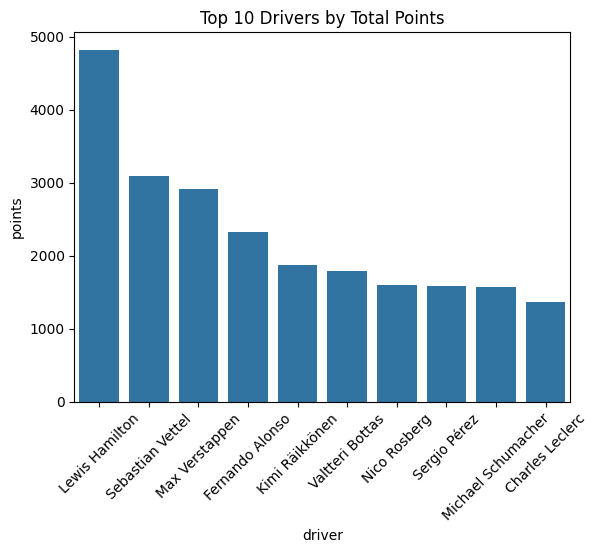

In [8]:

# Visualization: Top 10 drivers by total points 
import matplotlib.pyplot as plt

sns.barplot(
    data=df.groupby('driver')['points'].sum().reset_index().sort_values('points', ascending=False).head(10),
    x='driver',
    y='points'
)
plt.xticks(rotation=45)
plt.title('Top 10 Drivers by Total Points')
plt.show()



<Axes: xlabel='team_performance', ylabel='Count'>

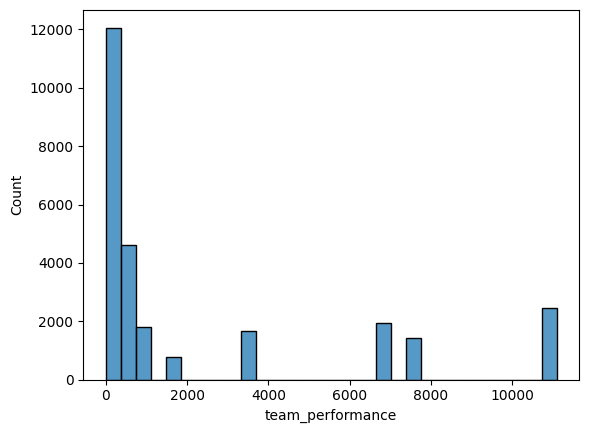

In [9]:

# Visualization: Team performance distribution

df['team_performance'] = df.groupby('constructor')['points'].transform('sum')
sns.histplot(data=df, x='team_performance', bins=30)


<Axes: ylabel='pos_corr'>

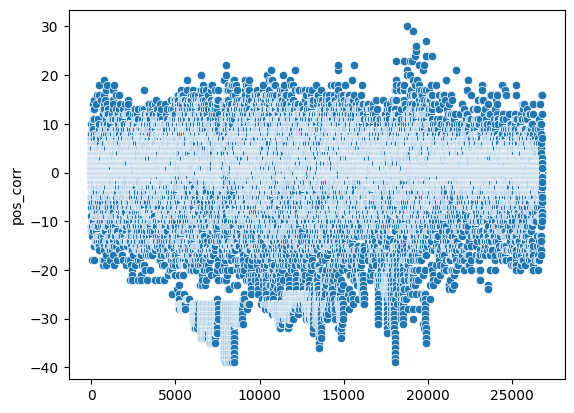

In [18]:
df['pos_corr'] = df['grid'] - df['positionOrder']

sns.scatterplot(df['pos_corr'])

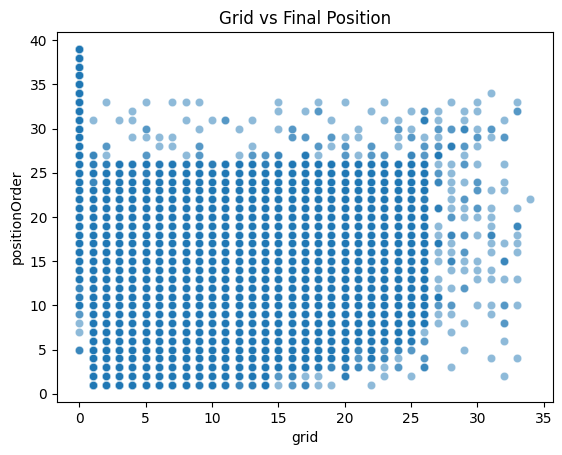

In [10]:
# Visualization: Grid vs Final Position

sns.scatterplot(data=df, x='grid', y='positionOrder', alpha=0.5)
plt.title('Grid vs Final Position')
plt.show()

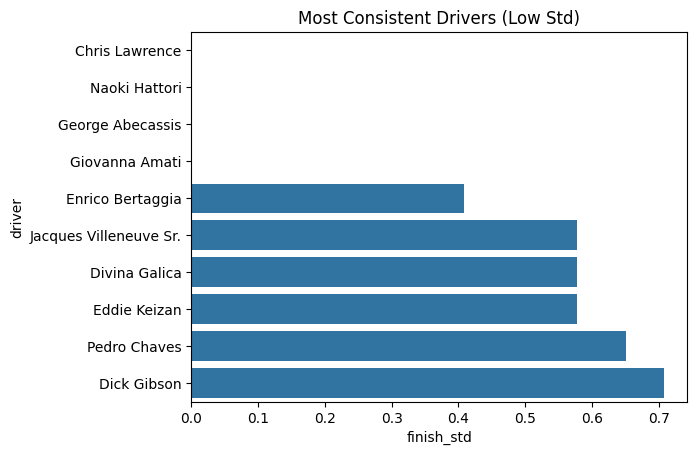

In [11]:
consistency = df.groupby('driver')['positionOrder'].agg(['mean','std']).reset_index()
consistency.rename(columns={'mean':'avg_finish','std':'finish_std'}, inplace=True)
sns.barplot(data=consistency.sort_values('finish_std').head(10), x='finish_std', y='driver')
plt.title('Most Consistent Drivers (Low Std)')
plt.show()


In [ ]:
# Creating a copy of the master dataframe


f1_df = df

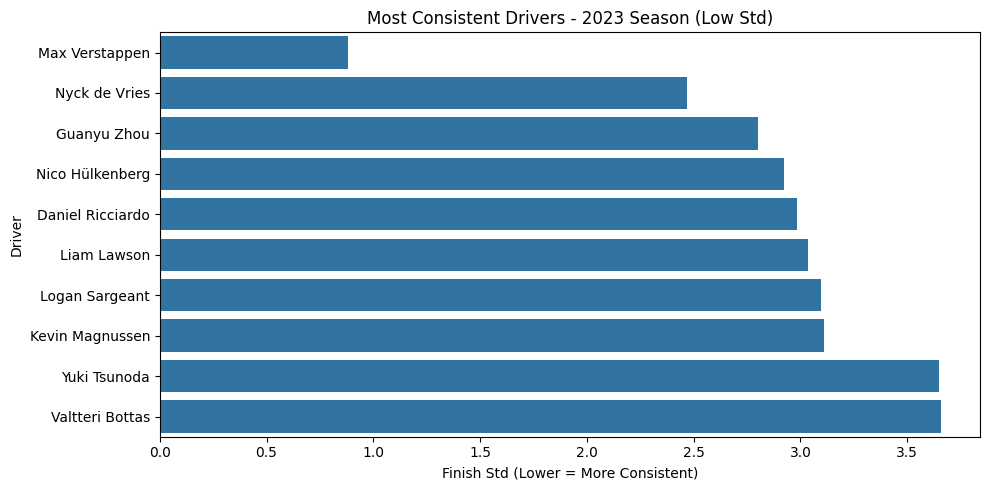

In [14]:
# Filter for the 2023 season
f1_2023 = f1_df[f1_df['year'] == 2023]

# Calculate consistency for 2023 drivers
consistency_2023 = (
    f1_2023.groupby('driver')['positionOrder']
    .agg(['mean', 'std'])
    .reset_index()
    .rename(columns={'mean': 'avg_finish', 'std': 'finish_std'})
)

# Get top 10 most consistent drivers
consistency_2023 = consistency_2023.sort_values('finish_std', ascending=True).head(10)

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.barplot(data=consistency_2023, x='finish_std', y='driver')
plt.title('Most Consistent Drivers - 2023 Season (Low Std)')
plt.xlabel('Finish Std (Lower = More Consistent)')
plt.ylabel('Driver')
plt.tight_layout()
plt.show()





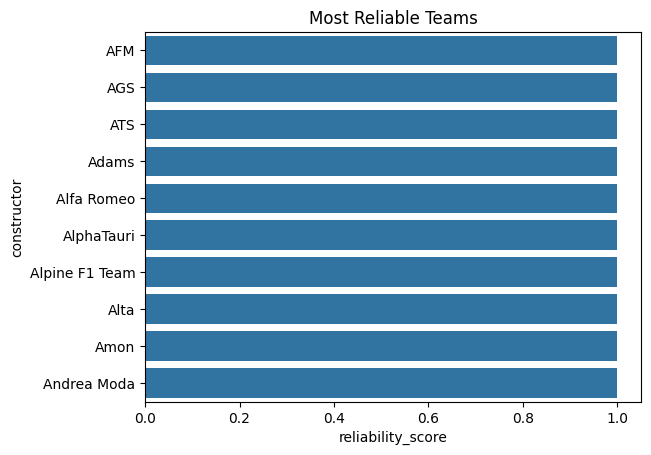

In [15]:
reliability = df.groupby('constructor')['dnf'].mean().reset_index()
reliability['reliability_score'] = 1 - reliability['dnf']
sns.barplot(data=reliability.sort_values('reliability_score', ascending=False).head(10),
            x='reliability_score', y='constructor')
plt.title('Most Reliable Teams')
plt.show()


Driver Performance Index (DPI)

In [16]:
driver_stats = df.groupby('driver').agg({'points':'sum','dnf':'mean','positions_gained':'mean'}).reset_index()
driver_stats['performance_index'] = (
    (driver_stats['points']/driver_stats['points'].max())*0.6 +
    ((1-driver_stats['dnf'])*0.2) +
    ((driver_stats['positions_gained']-driver_stats['positions_gained'].min()) /
     (driver_stats['positions_gained'].max()-driver_stats['positions_gained'].min())*0.2)
)
driver_stats.sort_values('performance_index', ascending=False).head(10)





,driver,points,dnf,positions_gained,performance_index
523,Lewis Hamilton,4820.5,0.0,-0.719101,0.923281
765,Sebastian Vettel,3098.0,0.0,-0.826667,0.708536
571,Max Verstappen,2912.5,0.0,-0.688995,0.685892
256,Fernando Alonso,2329.0,0.0,0.086634,0.615774
502,Kimi Räikkönen,1873.0,0.0,-0.963068,0.555621
831,Valtteri Bottas,1788.0,0.0,-1.105263,0.544581
768,Sergio Pérez,1585.0,0.0,0.109541,0.523243
614,Nico Rosberg,1594.5,0.0,-1.349515,0.519706
578,Michael Schumacher,1566.0,0.0,-2.012987,0.514013
132,Charles Leclerc,1363.0,0.0,-1.114094,0.491653


In [42]:
driver_stats.sort_values('performance_index', ascending=False).head(10)

,driver,points,dnf,positions_gained,performance_index
523,Lewis Hamilton,4820.5,0.0,-0.719101,0.923281
765,Sebastian Vettel,3098.0,0.0,-0.826667,0.708536
571,Max Verstappen,2912.5,0.0,-0.688995,0.685892
256,Fernando Alonso,2329.0,0.0,0.086634,0.615774
502,Kimi Räikkönen,1873.0,0.0,-0.963068,0.555621
831,Valtteri Bottas,1788.0,0.0,-1.105263,0.544581
768,Sergio Pérez,1585.0,0.0,0.109541,0.523243
614,Nico Rosberg,1594.5,0.0,-1.349515,0.519706
578,Michael Schumacher,1566.0,0.0,-2.012987,0.514013
132,Charles Leclerc,1363.0,0.0,-1.114094,0.491653
